Time series analysis
------

A time series analysis conducted. 

Following tutorials such as: 
- http://iot-ee.com/en/2017/08/07/analysing-iot-data-introduction-time-series-forecasting-python/

In [1]:
import pandas as pd
import numpy as np
import itertools

In [2]:
import matplotlib
import matplotlib.pyplot as plt

% matplotlib inline

In [3]:
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [4]:
font = {'size'   : 10,
        'weight': 'bold'}
matplotlib.rc('font', **font)

**Read in and Prepare data.**

In [5]:
df = pd.read_json('../data/data_nov_2017_clean.json')

In [6]:
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y')
yrl = df.groupby(['unique_key', 'date']).size().reset_index().groupby('date').size()
yrl = yrl.astype('float64')

In [7]:
total_articles = len(yrl)

**Rolling average.**

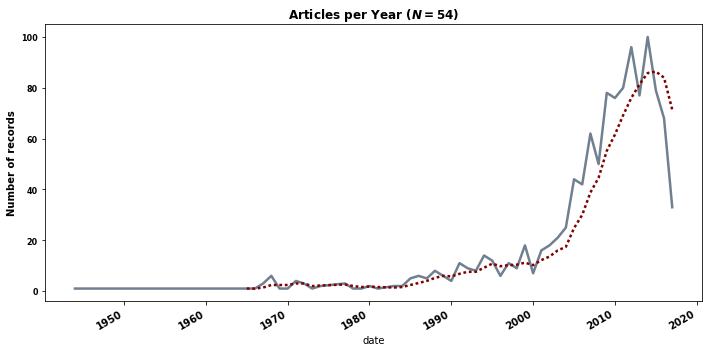

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Articles per Year ($N={}$)'.format(total_articles), fontweight='bold')
plt.ylabel('Number of records', fontweight='bold')
ax.plot(yrl, color='slategray', zorder=1, linewidth=2.5)
plt.xticks(fontsize=10); plt.yticks(fontsize=8)

ax = yrl.rolling(5).mean().plot(linewidth=2.5, color='maroon', linestyle=':');

plt.tight_layout()


# plt.savefig("/home/nightwing/rsc/Literature-Article/assets/images/timeseries.pdf",
#            format='pdf', bbox_inches='tight')

**Rolling average without arXiv.**

In [9]:
without_arxiv_df = df[df['provenance']!='arXiv']

In [10]:
yrl_without_arxiv = without_arxiv_df.groupby(['unique_key', 'date']).size().reset_index().groupby('date').size()
yrl_without_arxiv = yrl_without_arxiv.astype('float64')

In [11]:
total_articles = len(yrl_without_arxiv)

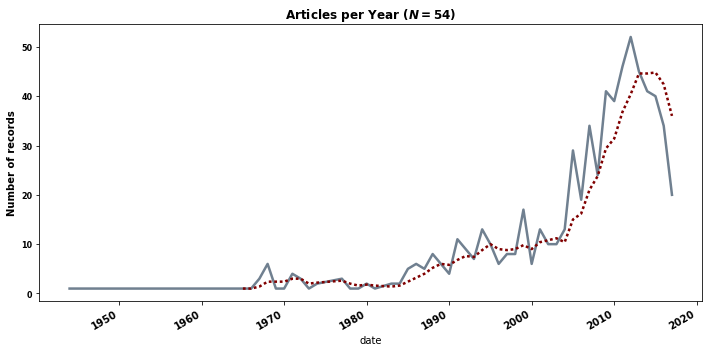

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Articles per Year ($N={}$)'.format(total_articles), fontweight='bold')
plt.ylabel('Number of records', fontweight='bold')
ax.plot(yrl_without_arxiv, color='slategray', zorder=1, linewidth=2.5)
plt.xticks(fontsize=10); plt.yticks(fontsize=8)

ax = yrl_without_arxiv.rolling(5).mean().plot(linewidth=2.5, color='maroon', linestyle=':');

plt.tight_layout()

**Stationary.**

In [13]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=5).mean()
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [14]:
def Dickey_Fuller_p_value(timeseries):
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    return dfoutput['p-value']

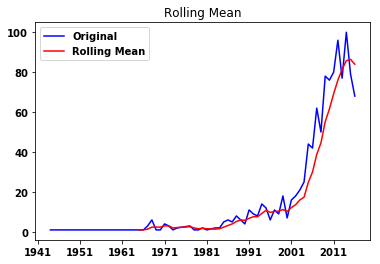

Results of Augmented Dickey-Fuller test:
Test Statistic                  2.079463
p-value                         0.998768
#Lags Used                     11.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


In [26]:
test_stationarity(yrl[:'2016-01-01'])

/home/nightwing/anaconda3/envs/literature/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  if __name__ == '__main__':


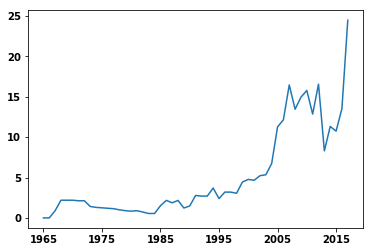

In [25]:
plt.plot(pd.rolling_std(yrl, window=5))

**Residuals.**

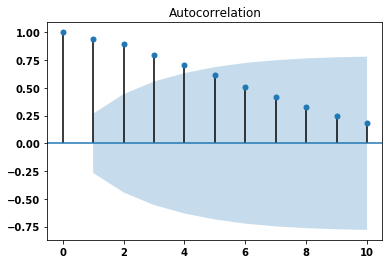

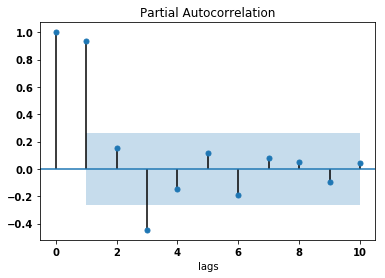

In [31]:
plot_acf(yrl, lags=10)
plot_pacf(yrl, lags=10)
plt.xlabel('lags')
plt.show()

**Choosing parameters.**

In [29]:
p = b = q = range(0, 2)
pq = itertools.product(p, b, q)
for param in pq:
    try:
        mod = ARIMA(yrl,order=param)
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        print(pq)

ARMA(0, 0, 0) - AIC:519.6714347975285
ARMA(0, 0, 1) - AIC:477.5086351948131
ARMA(0, 1, 0) - AIC:397.3360066163878


/home/nightwing/anaconda3/envs/literature/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/nightwing/anaconda3/envs/literature/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


ARMA(0, 1, 1) - AIC:396.3406612952392
ARMA(1, 0, 0) - AIC:406.77351541182924
ARMA(1, 0, 1) - AIC:406.72739356848217
ARMA(1, 1, 0) - AIC:393.259249674315
ARMA(1, 1, 1) - AIC:391.32953798781807


/home/nightwing/anaconda3/envs/literature/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/nightwing/anaconda3/envs/literature/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/nightwing/anaconda3/envs/literature/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtyp

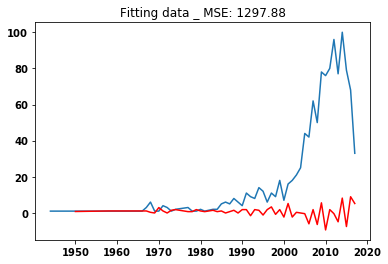

In [30]:
model = ARIMA(yrl, order=(1, 1, 0))  
results_MA = model.fit()  
plt.plot(yrl)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-yrl)**2).mean()))
plt.show()

**Forecast.**

In [31]:
forecast = results_MA.forecast(10)
forecast

(array([47.20276991, 42.96977524, 45.64446923, 45.73092434, 46.78716556,
        47.48003804, 48.309061  , 49.08706979, 49.88419306, 50.67415434]),
 array([ 9.32802634, 11.00158806, 13.1167898 , 14.70702975, 16.21798435,
        17.57305481, 18.84015622, 20.02397121, 21.14276548, 22.20484663]),
 array([[28.92017424, 65.48536558],
        [21.40705887, 64.53249162],
        [19.93603363, 71.35290483],
        [16.90567572, 74.55617297],
        [15.00050033, 78.5738308 ],
        [13.03748352, 81.92259256],
        [11.38303335, 85.23508865],
        [ 9.8408074 , 88.33333219],
        [ 8.44513418, 91.32325194],
        [ 7.15345466, 94.19485402]]))

In [32]:
forecast = pd.DataFrame(forecast[0], columns=['Forecast'])

In [44]:
forecast.index = ['20{}-01-01'.format(i) for i in range(18, 28)]

In [45]:
forecast

,Forecast
2018-01-01,47.202770
2019-01-01,42.969775
2020-01-01,45.644469
2021-01-01,45.730924
2022-01-01,46.787166
2023-01-01,47.480038
2024-01-01,48.309061
2025-01-01,49.087070
2026-01-01,49.884193
2027-01-01,50.674154


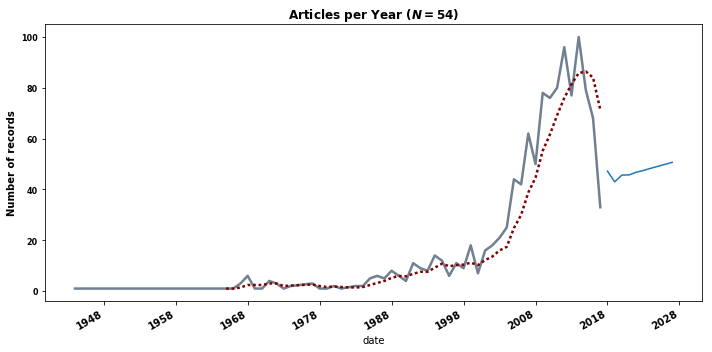

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Articles per Year ($N={}$)'.format(total_articles), fontweight='bold')
plt.ylabel('Number of records', fontweight='bold')
ax.plot(yrl, color='slategray', zorder=1, linewidth=2.5)
ax.plot(forecast)
plt.xticks(fontsize=10); plt.yticks(fontsize=8)

ax = yrl.rolling(5).mean().plot(linewidth=2.5, color='maroon', linestyle=':');

plt.tight_layout()

In [47]:
file = open("/home/nightwing/rsc/Literature-Article/assets/predictions.tex", 'w')
file.write('{}'.format(forecast.to_latex()))
file.close()

**Forecasting 'inclomplete' periods.**

In [35]:
without_2017 = yrl.ix[:'2016-01-01']

In [69]:
for i in range(2, 8):
    upper_year = '201{}-01-01'.format(i)
    without_df = yrl.ix[:upper_year]
    
    p_value = Dickey_Fuller_p_value(without_df)
    
    print('Up to {}:{}'.format(upper_year, p_value))

Up to 2012-01-01:1.0
Up to 2013-01-01:0.9988923319245885
Up to 2014-01-01:1.0
Up to 2015-01-01:1.0
Up to 2016-01-01:0.9987677138354604
Up to 2017-01-01:3.838572425551771e-07


In [47]:
k['p-value']

0.9987677138354604